In [2]:
import numpy as np
import gym
import matplotlib.pyplot as plt

## basics

- $\theta$ 与 $\pi_\theta(s,a)$（给定 $\theta$（策略参数） 关于 s, a 的函数），基于 $\theta$ 找到 $\pi_\theta$
    - $\theta$ 是策略参数
    - $\pi_\theta(s,a)$ 是策略（base $\theta$，policy)
    - $\pi$ 表示 distribution
- 策略迭代（策略梯度，policy gradient）的含义
    - $\theta_0\rightarrow \pi_0$, $\theta_0 \rightarrow \theta_1$, $\theta_1 \rightarrow \pi_1$

## 更新 pi 的计算方式

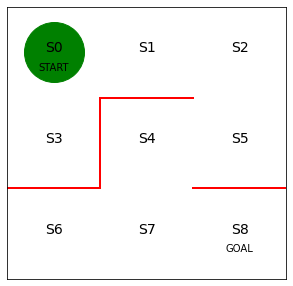

In [3]:
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)

# plt.plot([1, 1], [0, 1], color='red', linewidth=2)
# plt.plot([1, 2], [2, 2], color='red', linewidth=2)
# plt.plot([2, 2], [2, 1], color='red', linewidth=2)
# plt.plot([2, 3], [1, 1], color='red', linewidth=2)

plt.plot([2, 3], [1, 1], color='red', linewidth=2)
plt.plot([0, 1], [1, 1], color='red', linewidth=2)
plt.plot([1, 1], [1, 2], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)

plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')
# plt.axis('off')
plt.tick_params(axis='both', which='both', 
                bottom=False, top=False, 
                right=False, left=False,
                labelbottom=False, labelleft=False
               )
line, = ax.plot([0.5], [2.5], marker='o', color='g', markersize=60)

In [6]:
# border & barrier
# ↑, →, ↓, ←（顺时针）
# row index: given state
# col index: posible action
# (state, action) matrix
# 跟环境对齐
theta_0 = np.asarray([[np.nan, 1, 1, np.nan],      # s0
                      [np.nan, 1, np.nan, 1],      # s1
                      [np.nan, np.nan, 1, 1],      # s2
                      [1, np.nan, np.nan, np.nan], # s3 
                      [np.nan, 1, 1, np.nan],      # s4
                      [1, np.nan, np.nan, 1],      # s5
                      [np.nan, 1, np.nan, np.nan], # s6 
                      [1, 1, np.nan, 1]]           # s7
                     )

In [4]:
# 基于占比, 最 naive 的概率化方式
def cvt_theta_0_to_pi(theta):
    m, n = theta.shape
    pi = np.zeros((m, n))
    for r in range(m):
        pi[r, :] = theta[r, :] / np.nansum(theta[r, :])
    return np.nan_to_num(pi)

In [7]:
cvt_theta_0_to_pi(theta_0)

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.33333333, 0.33333333, 0.        , 0.33333333]])

$$
\begin{split}
\mathbb P_{k} & = \frac{\exp(z_k\cdot \beta)}{\sum_i \exp(z_i\cdot \beta)}\\
&=\frac{\exp(\frac{z_k}T)}{\sum_i \exp(\frac{z_i}T)}=\frac{\exp(\beta\cdot{z_k})}{\sum_i \exp(\beta\cdot{z_i})}
\end{split}
$$

In [8]:
# 基于 softmax，更 general 的概率化方式
def softmax_cvt_theta_0_to_pi(theta, beta=1.0):
    m, n = theta.shape
    pi = np.zeros((m, n))
    exp_theta = np.exp(theta*beta)
    for r in range(m):
        pi[r, :] = exp_theta[r, :]/np.nansum(exp_theta[r, :])
    pi = np.nan_to_num(pi)
    return pi

In [9]:
softmax_cvt_theta_0_to_pi(theta_0)

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.33333333, 0.33333333, 0.        , 0.33333333]])

## 与环境（Env）交互

In [10]:
# 维护着状态，以及 step 函数的返回
class MazeEnv(gym.Env):
    def __init__(self):
        self.state = 0
        pass
    
    def reset(self):
        self.state = 0
        return self.state
    
    def step(self, action):
        if action == 0:
            self.state -= 3
        elif action == 1:
            self.state += 1
        elif action == 2:
            self.state += 3
        elif action == 3:
            self.state -= 1
        done = False
        if self.state == 8:
            done = True
        # state, reward, done, _
        return self.state, 1, done, {}

$$
\begin{split}
&\theta_{s_i,a_j}=\theta_{s_i,a_j}+\eta\cdot \Delta \theta_{s,a_j}\\
&\Delta \theta_{s,a_j}=\frac{1}T\cdot \left(N(s_i,a_j) - P(s_i,a_j)N(s_i,a)\right)
\end{split}
$$

In [12]:
# 动作策略选择，基于当前环境的状态
class Agent:
    def __init__(self):
        self.actions = list(range(4))
        self.theta_0 = np.asarray([[np.nan, 1, 1, np.nan],      # s0
                      [np.nan, 1, np.nan, 1],      # s1
                      [np.nan, np.nan, 1, 1],      # s2
                      [1, np.nan, np.nan, np.nan], # s3 
                      [np.nan, 1, 1, np.nan],      # s4
                      [1, np.nan, np.nan, 1],      # s5
                      [np.nan, 1, np.nan, np.nan], # s6 
                      [1, 1, np.nan, 1]]           # s7
                     )
#         self.pi = self._cvt_theta_0_to_pi(self.theta_0)
        self.theta = self.theta_0
        self.pi = self._softmax_cvt_theta_to_pi()
        
        self.eta = 0.1
        
    def _cvt_theta_to_pi(self):
        m, n = self.theta.shape
        pi = np.zeros((m, n))
        for r in range(m):
            pi[r, :] = self.theta[r, :] / np.nansum(self.theta[r, :])
        return np.nan_to_num(pi)
    
    def _softmax_cvt_theta_to_pi(self, beta=1.):
        m, n = self.theta.shape
        pi = np.zeros((m, n))
        exp_theta = np.exp(self.theta*beta)
        for r in range(m):
            pi[r, :] = exp_theta[r, :] / np.nansum(exp_theta[r, :])
        return np.nan_to_num(pi)
    
    def update_theta(self, s_a_history):
        T = len(s_a_history) - 1
        m, n = self.theta.shape
        delta_theta = self.theta.copy()
        for i in range(m):
            for j in range(n):
                if not(np.isnan(self.theta_0[i, j])):
                    sa_i = [sa for sa in s_a_history if sa[0] == i]
                    sa_ij = [sa for sa in s_a_history if (sa[0] == i and sa[1] == j)]
                    N_i = len(sa_i)
                    N_ij = len(sa_ij)
                    delta_theta[i, j] = (N_ij - self.pi[i, j]*N_i)/T
        self.theta = self.theta + self.eta * delta_theta
        return self.theta
    
    def update_pi(self):
        self.pi = self._softmax_cvt_theta_to_pi()
        return self.pi
    
    def choose_action(self, state):
        # 依概率分布 \pi_\theta 选择 action
        action = np.random.choice(self.actions, p=self.pi[state, :])
        return action

In [13]:
env = MazeEnv()
agent = Agent()

In [15]:
state = env.state
# state, action
# trajectory
s_a_history = [[state, np.nan]]

In [16]:
while True:
    action = agent.choose_action(state)
    s_a_history[-1][1] = action
    state, reward, done, _ = env.step(action)
#     print(action, state, done)
    s_a_history.append([state, np.nan])
    if state == 8 or done:
        break

In [18]:
len(s_a_history)

41

## update $\theta$ and $\pi_\theta$ base policy gradient

- $\theta_{s_i, a_j} = \theta_{s_i, a_j} + \eta \Delta\theta_{s_i, a_j}$
- $\Delta\theta_{s_i, a_j}=\frac{N(s_i, a_j)-P(s_i,a_j)\cdot N(s_i, a)}{T}$

In [19]:
env = MazeEnv()
agent = Agent()
state = 0
# state, action
s_a_history = [[state, np.nan]]
while True:
    action = agent.choose_action(state)
    s_a_history[-1][1] = action
    state, reward, done, _ = env.step(action)
#     print(action, state, done)
    s_a_history.append([state, np.nan])
    if state == 8 or done:
        break

In [20]:
agent.update_theta(s_a_history)

array([[       nan, 0.99852941, 1.00147059,        nan],
       [       nan, 1.        ,        nan, 1.        ],
       [       nan,        nan, 0.99926471, 1.00073529],
       [1.        ,        nan,        nan,        nan],
       [       nan, 1.00220588, 0.99779412,        nan],
       [0.99926471,        nan,        nan, 1.00073529],
       [       nan, 1.        ,        nan,        nan],
       [0.9995098 , 1.00098039,        nan, 0.9995098 ]])

In [21]:
agent._softmax_cvt_theta_to_pi()

array([[0.        , 0.49926471, 0.50073529, 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.49963235, 0.50036765],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.50110294, 0.49889706, 0.        ],
       [0.49963235, 0.        , 0.        , 0.50036765],
       [0.        , 1.        , 0.        , 0.        ],
       [0.33316989, 0.33366021, 0.        , 0.33316989]])

## 完整训练及更新

In [22]:
stop_eps = 1e-4

In [23]:
agent = Agent()
env = MazeEnv()

while True:
    
    # 不断地从初始状态出发，产生一次 trajectory
    state = env.reset()
    # state, action
    s_a_history = [[state, np.nan]]
    while True:
        action = agent.choose_action(state)
        s_a_history[-1][1] = action
        state, reward, done, _ = env.step(action)
    #     print(action, state, done)
        s_a_history.append([state, np.nan])
        if state == 8 or done:
            break
            
    # 更新 theta
    agent.update_theta(s_a_history)
    pi = agent.pi.copy()
    # 更新 pi
    agent.update_pi()
    
    delta = np.sum(np.abs(agent.pi - pi))
    print(len(s_a_history), delta)
    if delta < stop_eps:
        break

37 0.01928929328034712
31 0.008002824141745524
13 0.02851717851279051
83 0.004046183159208738
69 0.014074307001285424
21 0.011890748316329025
49 0.01142418277138596
35 0.0101541740857779
31 0.018853306534993175
97 0.009836789843288396
35 0.00882178222325225
9 0.036635396525653285
19 0.036138338348715604
91 0.010868527151705776
11 0.033951583867316004
17 0.024395307321449733
9 0.04186778135450525
47 0.008227330961328827
25 0.012478226587882668
47 0.0137082874237478
27 0.01254333340805941
9 0.03579836943086534
29 0.01465675466660582
109 0.0110227404144152
53 0.013739335210697479
37 0.012308461841898377
25 0.006637742686934012
79 0.008689991230697136
23 0.020533639692068673
13 0.02789193757005254
41 0.012372313596542617
23 0.029132295439726008
143 0.011795418603541663
77 0.012368886227337617
89 0.009391794480802906
77 0.01179284633781108
117 0.013610518245104841
35 0.012986939260972663
19 0.012430335925464775
47 0.019421377923990568
9 0.03504725718093077
21 0.011982893154294016
27 0.01180

11 0.02205897215300054
15 0.013962417382844372
19 0.010465685719265233
13 0.013684598285318123
37 0.020630627813889663
7 0.02781696420107513
39 0.016820052585622414
13 0.020553310328610908
11 0.015071242963950265
29 0.019238503788971656
31 0.016101424956889154
15 0.016269412365962577
7 0.027580017458737532
37 0.017785181573377357
9 0.01982443735504369
19 0.01658763477787137
21 0.015839701582891108
15 0.015964756820000037
15 0.011569923400033627
13 0.02417659021426452
15 0.01364392950527546
19 0.015603533208621262
33 0.017508777482931892
13 0.021553840613096342
19 0.017564283146499382
29 0.014165616924630475
13 0.015302168673300087
9 0.02456413796960541
31 0.01431699888819199
11 0.027779454959150768
31 0.018621442583921732
13 0.013726098792072872
13 0.011507116398850353
11 0.019911361670138017
7 0.02710216810013666
19 0.018841242781866357
7 0.026778211828182602
9 0.023812828487083604
9 0.02372560336718768
13 0.0109187102590865
13 0.015120646186976006
11 0.026942847383174234
13 0.0161273

9 0.012976827359456655
15 0.014145224243058613
11 0.014600140525350053
9 0.014386401602913712
9 0.01322173383915104
13 0.017624900542150684
7 0.011516892132558298
11 0.014163404542806124
13 0.01573047287163068
23 0.012833469222909594
21 0.01264097880415388
11 0.01170988854645888
11 0.015868442131553473
7 0.011637513526556537
9 0.011395212954336459
9 0.014269019388272547
7 0.01147844879459814
7 0.011379149880498929
9 0.0098918917063541
9 0.013026393510358641
7 0.011224410770183352
9 0.011090332199433228
9 0.011038638978083992
7 0.011046844079423218
17 0.01688381663566632
13 0.013771146009244756
7 0.011022238023002284
9 0.010862091345792274
11 0.011751492923907841
15 0.01024185115369386
13 0.012839555441949507
9 0.010869763519233466
17 0.012972594772631935
7 0.01104215361593161
7 0.010948298647917298
11 0.01170021287616313
17 0.010892332302450597
11 0.0113494053678182
13 0.011770579855146457
9 0.009593218400457182
21 0.0145514736694915
7 0.01101752577651366
21 0.012347489569157821
7 0.01

7 0.004650827211109598
9 0.00655064465944738
9 0.006999631380099194
7 0.00464392740001178
7 0.004614786757044145
7 0.004585907198429204
7 0.004557285766242508
7 0.004528919541792242
7 0.0045008056450471234
7 0.004472941234079139
7 0.0044453235045087
7 0.004417949688960088
7 0.004390817056528357
9 0.006640375179455704
11 0.00830863556888195
9 0.0063680588670901594
7 0.00438760197313684
9 0.006472381489639814
7 0.004352717312895327
9 0.006626227731871034
7 0.004326803095084292
9 0.007223782415179569
7 0.0042990752750857175
11 0.008478412367373608
7 0.004299348250766652
7 0.004273355199159459
7 0.004247586666571129
7 0.004222040195840035
9 0.00651381650143075
7 0.004198120129403307
17 0.011108346557625007
9 0.006382129550657228
9 0.006566082361604025
7 0.00421211284668685
7 0.0041869190627900205
7 0.004161940850116078
7 0.004137175865907325
13 0.009066432816446673
7 0.004142854302587706
15 0.010783481933076655
7 0.004177125319618238
17 0.00914674391660103
7 0.004196503421589642
7 0.004171

7 0.0029553240057053898
7 0.002940057760866935
11 0.007373676728987491
13 0.006893888129628795
7 0.0029660116130039993
7 0.00295068552336121
9 0.0055002593501477515
7 0.0029507342233852374
7 0.002935490417573447
7 0.0029203611580188443
7 0.002905345332344253
9 0.004794413852539689
13 0.009549463582802037
9 0.005081969824004398
9 0.005555026431021723
7 0.002963654315640954
7 0.0029482171902150967
11 0.006866826397895154
9 0.005090843405553699
7 0.0029449919574061068
9 0.005580695306352718
13 0.008598813089124815
7 0.0029685786644473855
9 0.005096700038513993
7 0.002953530327936993
7 0.0029382049584786296
7 0.002922995676286469
7 0.0029079013403203874
7 0.002892920823123188
9 0.005540841944565111
9 0.0050186520202743085
11 0.007090381807356577
13 0.00749553644429353
7 0.0029374079819639715
7 0.0029222133636528785
7 0.002907133365233877
9 0.005503179135712508
7 0.0029087970536634117
7 0.0028937798157086664
11 0.006693806869699309
13 0.008658175360689663
11 0.005985659132095381
11 0.006003

7 0.0018528385350898915
7 0.001844954079210405
7 0.0018371196580400859
9 0.004441404814701962
9 0.004481099567921511
7 0.0018595556260544363
7 0.0018515685775291404
7 0.0018436329364234644
7 0.0018357482617300455
9 0.004235641421968431
7 0.001830943537446665
7 0.0018231508710822505
7 0.0018154078552708452
7 0.001807714068677413
7 0.0018000690944168021
9 0.0037957589505033043
7 0.001795806664641672
7 0.001788246141046751
7 0.0017807332349839486
7 0.0017732675471627962
7 0.0017658486824654249
9 0.0036647093561048907
7 0.0017650771449142857
9 0.004365091292618972
7 0.0017723937961783565
7 0.0017649568314685102
7 0.0017575666260522746
7 0.0017502227880118668
11 0.004811521485547088
7 0.0017511143652534436
7 0.00174382673850456
9 0.004102512368485946
7 0.00173988688429777
7 0.00173267836806585
7 0.001725514515043311
9 0.00373120191519484
7 0.0017240579210367896
7 0.001716951054111994
7 0.0017098879670107286
7 0.0017028683009756157
9 0.004278368368103962
9 0.004083716801668816
7 0.0017135584

7 0.001243043124070392
9 0.0030869843584088383
9 0.002790312363974881
9 0.003448781437116258
7 0.0012476442724644599
7 0.0012432542324728735
7 0.0012388872631985681
7 0.0012345432033425835
7 0.0012302218930166711
9 0.0028015146650347683
15 0.0055001202091121
7 0.00124149979658051
7 0.0012371565432063442
7 0.0012328359436051747
7 0.001228537840812921
11 0.003998057163567312
9 0.0035435025714812066
7 0.0012432495804120952
9 0.0034546271959613184
7 0.0012438865786916706
11 0.004128352559775075
13 0.00593397741512567
7 0.0012702696980611758
7 0.0012657572823297075
7 0.0012612688152874446
7 0.001256804127811026
9 0.003122341642614719
7 0.0012559739284520796
7 0.0012515416305801455
7 0.001247132686750578
7 0.0012427469333110008
7 0.001238384208041482
9 0.0034486498106049562
9 0.003128643664840808
7 0.0012428801349070942
7 0.0012385216904311352
7 0.0012341860427661014
7 0.0012298730335027416
7 0.001225582505605706
7 0.001221314303394505
9 0.002969512780506306
7 0.0012222329983169813
7 0.00121

9 0.0024705140706644327
7 0.0008495553661172148
7 0.0008470699234030127
7 0.000844595334775218
7 0.0008421315373259922
7 0.0008396784685993502
9 0.002547236637762171
7 0.0008424245641383485
7 0.0008399688557624366
9 0.0025674839160039695
7 0.0008428756486871317
7 0.0008404162647600785
7 0.0008379675949848134
7 0.0008355295774244292
7 0.0008331021505916039
7 0.0008306852534348541
7 0.0008282788253446624
7 0.0008258828061410498
7 0.0008234971360770518
7 0.0008211217558302189
11 0.004068780338457305
7 0.0008273317942031969
7 0.0008249387915721731
9 0.0027767001403037964
7 0.0008273343298806635
7 0.0008249399316325734
7 0.000822555882761096
11 0.0037131324969550336
9 0.002837708004800904
9 0.0027606853867398334
7 0.0008414990162740194
7 0.0008390331003493012
7 0.0008365779987977856
7 0.0008341336485723425
9 0.0027809713334571926
7 0.0008379594742814814
7 0.0008355049814340945
7 0.000833061258996251
7 0.0008306282440828858
7 0.0008282058742663523
7 0.0008257940875734601
7 0.0008233928224791

7 0.0006254223141406688
7 0.0006238433431817007
7 0.0006222703394539765
7 0.0006207032729346716
9 0.0024032304664352647
9 0.0023363841587275003
9 0.0023701698991438203
11 0.00301617231612784
9 0.0021657032795411833
7 0.0006397244109973103
7 0.000638089177442229
7 0.0006364602039906249
7 0.0006348374587278292
7 0.0006332209099430414
9 0.0021832109477902123
7 0.0006347742229103892
7 0.0006331586275179039
7 0.0006315491878626095
7 0.0006299458727246354
7 0.0006283486510805514
7 0.0006267574921021285
7 0.0006251723651577411
7 0.0006235932398068571
7 0.0006220200858023418
7 0.0006204528730858021
7 0.0006188915717873465
7 0.0006173361522267343
7 0.0006157865849059502
9 0.002176959473351732
7 0.0006175073953618611
7 0.0006159575735321422
7 0.000614413573073621
7 0.0006128753648873865
7 0.0006113429200578328
7 0.0006098162098510454
7 0.0006082952057070434
11 0.0031548036367765563
7 0.0006134914210142901
9 0.002374716190542945
7 0.0006159450465547528
7 0.0006143991850351659
7 0.0006128591319249

9 0.002015263961046395
7 0.00045556650543652696
9 0.002217150303519589
7 0.0004589183584425942
7 0.0004578989325385724
7 0.0004568829573580943
7 0.00045587041708718135
7 0.00045486129600591854
7 0.00045385557848289654
7 0.0004528532489771614
7 0.0004518542920396995
7 0.0004508586923087782
7 0.0004498664345125025
7 0.0004488775034661163
9 0.0015549208423421175
7 0.0004491744243304077
7 0.0004481895395978888
7 0.00044720794197915595
9 0.0017277488073191814
7 0.00044836509157114915
7 0.00044738406840827416
7 0.00044640630939290354
7 0.00044543179984216086
7 0.0004444605251613422
7 0.000443492470835527
7 0.0004425276224333634
7 0.0004415659656052777
7 0.0004406074860809489
7 0.00043965216967475906
7 0.0004387000022782993
7 0.00043775096986270814
7 0.00043680505847916787
7 0.0004358622542577524
9 0.0019777950844830847
7 0.0004385849437141785
7 0.0004376349146624145
7 0.0004366880158085708
7 0.0004357442332131069
9 0.002163511675507098
7 0.000438984924516949
7 0.0004380306850356973
7 0.00043

7 0.0003432310677987799
9 0.0014505409191501728
7 0.0003440404808607335
7 0.00034338407766391216
7 0.0003427295701550828
7 0.0003420769509657959
7 0.0003414262127642738
7 0.0003407773482529096
7 0.0003401303501712437
7 0.0003394852112922238
7 0.00033884192442853317
7 0.0003382004824229387
7 0.0003375608781551638
7 0.00033692310454078514
7 0.00033628715452739544
7 0.00033565302109797926
7 0.00033502069727046196
7 0.0003343901760945109
7 0.00033376145065644805
9 0.0017327075142856939
7 0.00033610275945181525
7 0.00033546795762267115
7 0.000334834972160844
7 0.00033420379606673156
7 0.000333574422374007
7 0.000332946844150802
7 0.00033232105449891927
7 0.00033169704655237886
7 0.000331074813480943
7 0.0003304543484856405
7 0.0003298356447991972
7 0.00032921869568975845
7 0.00032860349445624007
7 0.00032799003443112484
7 0.00032737830897613604
7 0.0003267683114880626
7 0.0003261600353940894
7 0.0003255534741527233
7 0.0003249486212543798
7 0.0003243454702200263
7 0.00032374401460236527
7 0

7 0.0002638929625236701
7 0.00026345656239408835
7 0.0002630212456680922
7 0.0002625870087534475
7 0.0002621538480740253
7 0.0002617217600693819
11 0.0021285681678989456
7 0.00026448747710247633
7 0.00026404934834525773
7 0.00026361230921729054
7 0.0002631763561014716
7 0.0002627414853940413
7 0.00026230769350772676
7 0.00026187497686971234
7 0.0002614433319219657
7 0.0002610127551213072
7 0.00026058324293865703
7 0.00026015479186140486
7 0.00025972739838718215
7 0.0002593010590338646
7 0.0002588757703289764
7 0.00025845152881648
7 0.0002580283310545488
7 0.00025760617361439767
7 0.0002571850530826772
7 0.00025676496605901364
7 0.00025634590915828495
7 0.0002559278790075607
7 0.00025551087224767385
7 0.00025509488553645057
7 0.0002546799155407932
7 0.00025426595894428167
7 0.00025385301244378045
7 0.00025344107274806113
9 0.0012567929901390572
7 0.0002542896581138737
7 0.00025387704336946385
7 0.00025346543313420344
7 0.00025305482414685054
7 0.0002526452131566548
9 0.00148354499594866

7 0.0002356032525451853
9 0.001101329051711144
7 0.00023602217733807197
7 0.0002356503303441778
7 0.00023527936632655386
7 0.0002349092824756524
7 0.00023454007599393867
7 0.00023417174409490898
7 0.0002338042840023466
7 0.00023343769295156545
7 0.0002330719681900434
7 0.00023270710697353286
7 0.00023234310657199546
7 0.0002319799642635078
7 0.00023161767733803282
7 0.00023125624309646917
7 0.0002308956588504274
7 0.00023053592192086823
7 0.00023017702964215833
7 0.00022981897935541416
7 0.0002294617684157358
7 0.00022910539418638347
7 0.00022874985404219318
7 0.00022839514536804328
7 0.00022804126555867575
9 0.0011014397397540471
7 0.00022851719820235136
9 0.0012313427537289385
7 0.00022948591340615776
7 0.00022913027529039565
9 0.001235442801072184
7 0.00023033710692333363
7 0.00022997940303918878
7 0.00022962253522679568
7 0.00022926650087170576
7 0.0002289112973688015
7 0.0002285569221252351
7 0.000228203372555736
9 0.0011141395419971521
7 0.00022871908243930587
9 0.001441986132564

7 0.0002028692620836027
9 0.0013510395262555513
9 0.001306391182554937
7 0.00020604522739374811
7 0.00020573925895331704
7 0.00020543397804322246
7 0.00020512938258778098
7 0.00020482547051930804
7 0.0002045222397777241
7 0.00020421968831048354
7 0.00020391781407476037
11 0.0017483837635156856
7 0.0002058351990461317
7 0.00020552984939018956
7 0.00020522518496225717
7 0.0002049212036975296
7 0.00020461790353864563
7 0.000204315282435686
7 0.00020401333834631392
9 0.0011902451016173564
7 0.00020525134507634428
9 0.0012753906879979186
7 0.00020659859366640998
7 0.00020629108354110713
7 0.00020598426619735863
7 0.0002056781395364561
9 0.001357313833909449
7 0.00020716202816761266
7 0.0002068527797868258
7 0.00020654423075368994
9 0.0010139730180327988
7 0.00020693368262447026
9 0.0012916327795439875
7 0.00020832804731197273
7 0.00020801644072289925
7 0.00020770553996753323
9 0.0013133575496865422
7 0.00020917406095805405
7 0.00020886016980941474
7 0.00020854699240541175
7 0.00020823452656

7 0.00017005545741520696
7 0.00016982481306543687
9 0.0011252012871927099
7 0.00017088880315694818
7 0.00017065639467913132
7 0.0001704244657455018
7 0.0001701930150221284
7 0.00016996204118285667
7 0.00016973154290455574
9 0.000949244571443339
7 0.00017025705613578183
7 0.00017002630167289694
7 0.00016979602131791602
7 0.0001695662137615201
7 0.00016933687769669394
7 0.00016910801182152234
7 0.000168879614840807
7 0.00016865168546033836
9 0.0011208323776639752
7 0.0001698621973355765
7 0.00016963192277335074
7 0.00016940212184134683
7 0.00016917279322864812
9 0.0009610213512667859
7 0.0001697311151051071
7 0.00016950144361662853
9 0.0011908331242853863
9 0.0012139704783479515
7 0.0001721412733621374
9 0.0012365729645029844
7 0.00017344793416104905
7 0.00017320972196671787
7 0.00017297200672181795
7 0.00017273478702982056
7 0.00017249806149755714
7 0.00017226182873940864
7 0.00017202608737198338
7 0.00017179083601946525
7 0.0001715560733076167
11 0.0013850166480345871
7 0.0001726452802

7 0.00016063446461040722
7 0.0001604226212231323
11 0.0014043676433319885
7 0.00016161826183933893
7 0.000161404888670294
7 0.0001611919432136094
7 0.0001609794243139593
7 0.00016076733081677765
7 0.00016055566157475824
7 0.00016034441544245798
7 0.0001601335912788434
7 0.00015992318794627938
7 0.00015971320431263682
7 0.0001595036392474155
7 0.00015929449162603235
7 0.00015908576032638323
7 0.00015887744422946222
7 0.00015866954222426566
7 0.00015846205319529003
9 0.0010078083387247624
7 0.00015920526407540818
7 0.00015899688280331115
7 0.0001587889152839389
7 0.00015858136040969827
7 0.00015837421707754623
7 0.000158167484186943
7 0.0001579611606424905
9 0.0012496245171648174
7 0.00015944866453505326
7 0.00015923919226257417
7 0.00015903013825471074
7 0.00015882150138418934
7 0.00015861328052610944
7 0.00015840547456111818
7 0.00015819808237207272
9 0.0010191179663504649
7 0.00015897325924860845
7 0.0001587648895916647
7 0.00015855693474562532
7 0.0001583493935964301
7 0.000158142265

7 0.00014285949286000146
7 0.00014268084552001258
7 0.00014250253918437518
7 0.000142324572969834
7 0.00014214694599629964
9 0.0010747071191483677
7 0.00014336063953652653
9 0.0012211893279865643
7 0.00014484499545784277
9 0.0008966095259135987
7 0.00014537988029502888
7 0.00014519556799099526
9 0.0011025848262187204
7 0.000146487210893307
7 0.00014630022993007002
7 0.000146113615197346
7 0.00014592736571687227
11 0.0018742299496880693
9 0.0008810048330964524
7 0.00014920508752050074
7 0.0001490120296351663
7 0.00014881935618969028
9 0.0012758680428487101
7 0.0001504701339893992
7 0.00015027374396887026
7 0.00015007774955476567
7 0.00014988214965713266
7 0.00014968694318796827
7 0.0001494921290642985
9 0.000846942064827676
7 0.00014985540812602859
7 0.00014966064152522468
7 0.00014946626522092422
7 0.0001492722781423414
7 0.00014907867922434037
7 0.00014888546740280187
7 0.0001486926416203356
7 0.00014850020082162428
7 0.0001483081439547472
7 0.0001481164699722419
7 0.00014792517782959

7 0.0001312381927220472
9 0.0009282128269990676
7 0.00013191735071973153
7 0.00013175846507912196
7 0.00013159987148039266
7 0.0001314415691949615
7 0.00013128355749903592
7 0.0001311258356700741
7 0.00013096840298702436
7 0.0001308112587329463
7 0.00013065440219135402
7 0.0001304978326485979
7 0.000130341549394666
7 0.00013018555171903298
7 0.00013002983891540615
7 0.00012987441028005156
7 0.00012971926511019978
7 0.0001295644027041326
7 0.00012940982236648614
7 0.00012925552339985817
7 0.0001291015051105137
7 0.0001289477668082028
7 0.00012879430780192783
7 0.00012864112740648345
7 0.00012848822493532162
7 0.00012833559970637683
7 0.000128183251038581
9 0.0007818999357391901
9 0.0007922888400717538
7 0.00012911455240785172
7 0.0001289613243422756
7 0.00012880837323557895
7 0.00012865569841112763
7 0.00012850329919276114
7 0.0001283511749085916
7 0.00012819932488657322
7 0.000128047748458867
7 0.00012789644495835029
7 0.0001277454137199735
7 0.000127594654081754
7 0.000127444165382654

7 0.00010774690426874033
7 0.00010763031883262442
7 0.0001075139249026337
7 0.00010739772205619301
7 0.00010728170986936889
11 0.0014461723655127528
7 0.00010871982737506447
7 0.00010860146977478488
7 0.0001084833079052095
7 0.00010836534133012651
7 0.00010824756961353744
7 0.00010812999232242583
7 0.0001080126090237405
7 0.00010789541928599329
7 0.0001077784226791792
7 0.00010766161877446764
7 0.00010754500714330387
7 0.0001074285873604499
7 0.00010731235899860345
11 0.0012909018118712895
9 0.0009618264712212624
7 0.00010950354075460467
7 0.00010938371434759779
9 0.0010002284866902043
7 0.00011036358586722327
7 0.00011024210172629056
7 0.00011012082108459442
7 0.00010999974348204107
7 0.00010987886845877266
7 0.00010975819555884836
7 0.00010963772432526393
7 0.00010951745430278458
9 0.0010130161316659145
7 0.00011053146967990313
7 0.00011040944925451782
7 0.00011028763406157292
7 0.00011016602363310771
7 0.00011004461750535773
7 0.00010992341521410577
7 0.00010980241629678089
7 0.0001

9 0.0009638246676106164
7 0.0001018246772477218
7 0.00010171769407586739
7 0.0001016108814633973
7 0.00010150423904351294
7 0.00010139776645137419
7 0.0001012914633224983
7 0.00010118532929280499
7 0.00010107936400113524
7 0.00010097356708600388
7 0.0001008679381858165
7 0.00010076247694166922
7 0.00010065718299544918
7 0.00010055205598929334
7 0.00010044709556734227
7 0.00010034230137244762
7 0.00010023767305169205
7 0.00010013321024977817
7 0.00010002891261584428
7 9.992477979636587e-05


In [24]:
agent.pi

array([[0.        , 0.98782525, 0.01217475, 0.        ],
       [0.        , 0.98334014, 0.        , 0.01665986],
       [0.        , 0.        , 0.98558642, 0.01441358],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.01273671, 0.98726329, 0.        ],
       [0.01651377, 0.        , 0.        , 0.98348623],
       [0.        , 1.        , 0.        , 0.        ],
       [0.01417312, 0.97542647, 0.        , 0.01040041]])

In [25]:
env = MazeEnv()
state = env.reset()
# state, action
s_a_history = [[state, np.nan]]
while True:
    action = agent.choose_action(state)
    s_a_history[-1][1] = action
    state, reward, done, _ = env.step(action)
#     print(action, state, done)
    s_a_history.append([state, np.nan])
    if state == 8 or done:
        break

In [27]:
len(s_a_history)

7

In [28]:
from matplotlib import animation
from IPython.display import HTML

In [29]:
def init():
    line.set_data([], [])
    return (line, )
def animate(i):
    state = s_a_history[i][0]
    x = (state % 3)+0.5
    y = 2.5 - int(state/3)
    line.set_data(x, y)

In [30]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history), interval=200, repeat=False)

In [31]:
HTML(anim.to_jshtml())